## **Import Libraries**

In [1]:
import os
import pathlib
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetB0  
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **Functions**

In [2]:
SEED = 999

def build_network(base_model, classes):
    """
    Build a custom neural network architecture by adding fully connected layers on top of a pre-trained base model.

    Parameters:
        base_model (tf.keras.Model): Pre-trained base model without the fully connected layers.
        classes (int): Number of output classes.

    Returns:
        tf.keras.Model: Custom neural network model with the specified architecture.
    """
    x = Flatten()(base_model.output)
    x = Dense(units=1024)(x)
    x = ReLU()(x)
    #x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=classes)(x)
    output = Softmax()(x)
    return output

def load_images_and_labels(image_paths, target_size=(224, 224)): 
    """
    Load images and corresponding labels from file paths.

    Parameters:
        image_paths (list): List of file paths to the images.
        target_size (tuple): Target size to resize the images.

    Returns:
        tuple: A tuple containing two numpy arrays: 
            - The first array contains the loaded images with the specified target size.
            - The second array contains the corresponding labels extracted from the file paths.
   """
    images = []
    labels = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)

        label = image_path.split(os.path.sep)[-2]

        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/70


2024-01-27 18:21:03.049934: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


92/92 [==============================] - 56s 376ms/step - loss: 2.0203 - accuracy: 0.3269 - val_loss: 2.0497 - val_accuracy: 0.1680
Epoch 2/70
92/92 [==============================] - 31s 338ms/step - loss: 1.4601 - accuracy: 0.4733 - val_loss: 1.8613 - val_accuracy: 0.1924
Epoch 3/70
92/92 [==============================] - 31s 333ms/step - loss: 1.2627 - accuracy: 0.5538 - val_loss: 1.7782 - val_accuracy: 0.2832
Epoch 4/70
92/92 [==============================] - 31s 333ms/step - loss: 1.1543 - accuracy: 0.5792 - val_loss: 1.4504 - val_accuracy: 0.4648
Epoch 5/70
92/92 [==============================] - 31s 333ms/step - loss: 1.0661 - accuracy: 0.6127 - val_loss: 1.0599 - val_accuracy: 0.6084
Epoch 6/70
92/92 [==============================] - 31s 333ms/step - loss: 0.9990 - accuracy: 0.6463 - val_loss: 0.9991 - val_accuracy: 0.6409
Epoch 7/70
92/92 [==============================] - 30s 329ms/step - loss: 0.9223 - accuracy: 0.6563 - val_loss: 1.1697 - val_accuracy: 0.5786
Epoch 8/70

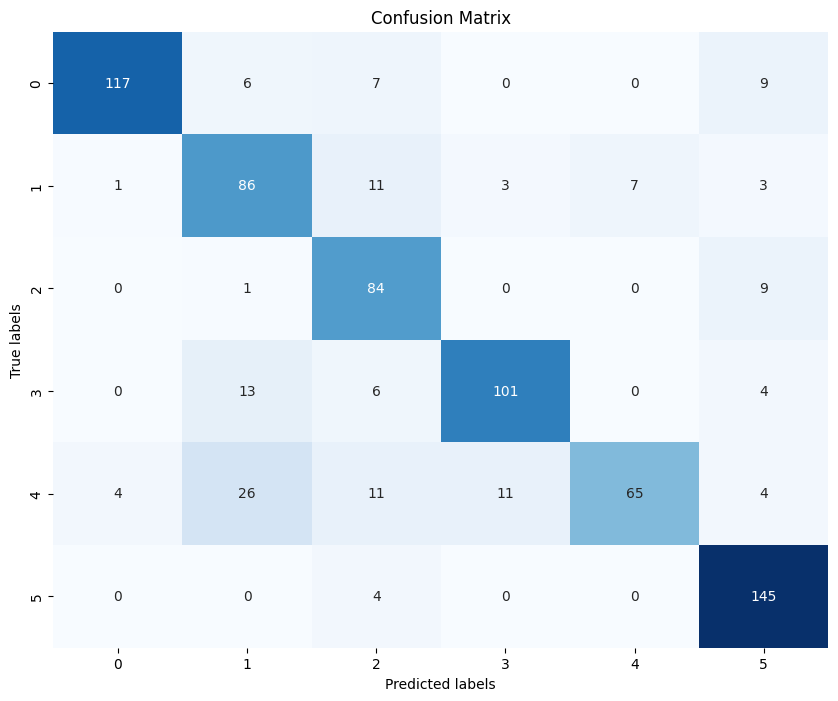

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to: /kaggle/working/fine_tuned_EffecientNET B7_model.h5


In [3]:
def main():
    """
    Main function to train and evaluate a deep learning model based on EffecientNET architecture.

    This function performs the following steps:
    1. Load images and corresponding labels from the specified dataset directory.
    2. Split the dataset into training and testing sets.
    3. Initialize a EffecientNET base model pre-trained on ImageNet.
    4. Build a custom neural network architecture on top of the base model for classification.
    5. Configure data augmentation and create a data generator for training.
    6. Train the model on the training data with a specified number of epochs using RMSprop optimizer.
    7. Evaluate the trained model on the testing data and print the test accuracy.
    8. Fine-tune the last layers of the base model and continue training with SGD optimizer.
    9. Save the trained model to a specified file path.

    Returns:
        history: History object containing training/validation loss and accuracy values.
    """
    
    dataset_path = pathlib.Path("/kaggle/input/dataset")
    files_pattern = (dataset_path / 'dataset' / '*' / '*.jpg')
    image_paths = [*glob(str(files_pattern))]
    CLASSES = {p.split(os.path.sep)[-2] for p in image_paths}

    X, y = load_images_and_labels(image_paths)
    X = X.astype('float') / 255.0
    y = LabelBinarizer().fit_transform(y)
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=SEED)

    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))  # Change this

    for layer in base_model.layers:
        layer.trainable = False

    model = build_network(base_model, len(CLASSES))
    model = Model(base_model.input, model)

    BATCH_SIZE = 32
    augmenter = ImageDataGenerator(rotation_range=45, horizontal_flip=True, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
    train_generator = augmenter.flow(X_train, y_train, BATCH_SIZE)

    '''EPOCHS = 20
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=["accuracy"])

    model.fit(train_generator, steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data=(X_test, y_test), epochs=EPOCHS)
    result = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {result[1]}')'''

    for layer in base_model.layers[15:]:
        layer.trainable = True

    EPOCHS = 70
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=1e-3), metrics=['accuracy'])

    history = model.fit(train_generator, steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data=(X_test, y_test), epochs=EPOCHS)
    result = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {result[1]}')
    
    # Predict the classes
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

     # Define class names
    class_names = ["Ajloun", "Jerash", "Petra", "RomanAmphitheater", "UmmQais", "WadiRum"]

   #    Print classification report with class names
    print("Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Save the model
    model_save_path = '/kaggle/working/fine_tuned_EffecientNET B7_model.h5'
    model.save(model_save_path)
    print(f"Model saved to: {model_save_path}")
    return history

if __name__ == '__main__':
    history = main()

## **Plot the learning curve**

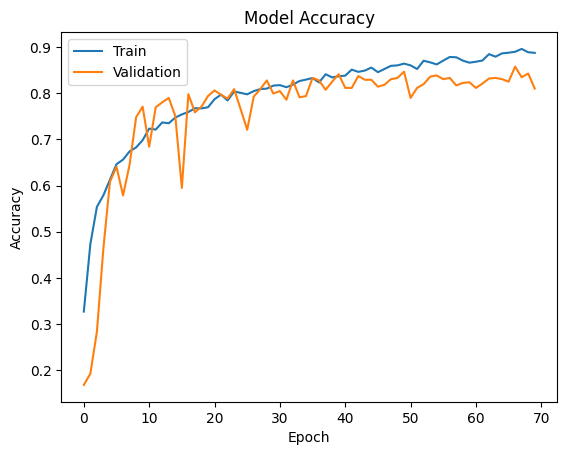

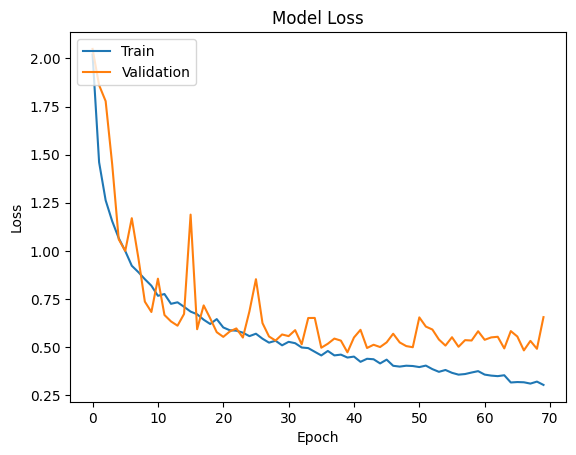

In [4]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Test our model**

1/1 [==============================] - 2s 2s/step


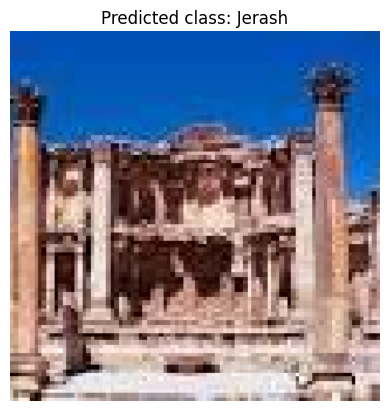

Predicted class: Jerash
Probability for Ajloun: 0.0003
Probability for Jerash: 0.9631
Probability for Petra: 0.0203
Probability for RomanAmphitheater: 0.0146
Probability for UmmQais: 0.0016
Probability for WadiRum: 0.0000


In [5]:
# Load the saved model
loaded_model = load_model('/kaggle/working/fine_tuned_EffecientNET B7_model.h5')  

# Load and preprocess a new image for prediction
original_img_path = '/kaggle/input/test-dataset/test/j2.jpeg'  
converted_img_path = '/kaggle/working/converted_image.jpg'  

# Convert the image to JPG format
img = Image.open(original_img_path)
img = img.convert("RGB")
img.save(converted_img_path, "JPEG")  

# Load the converted image
img = image.load_img(converted_img_path, target_size=(224, 224))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  

# Make a prediction
predictions = loaded_model.predict(img_array)


class_labels = ["Ajloun", "Jerash", "Petra", "RomanAmphitheater", "UmmQais", "WadiRum"]  

# Get the predicted class label
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]

# Get the probabilities for each class
class_probabilities = {label: prob for label, prob in zip(class_labels, predictions[0])}

# Plot the sample
plt.imshow(img)
plt.title(f'Predicted class: {predicted_class_label}')
plt.axis('off')
plt.show()

# Write predicted classes and probabilities
print(f"Predicted class: {predicted_class_label}")
for label, prob in class_probabilities.items():
    print(f"Probability for {label}: {prob:.4f}")


## **Extra Part: plot group of tesed image with actual and predicted labels**

1/1 [==============================] - 0s 30ms/step


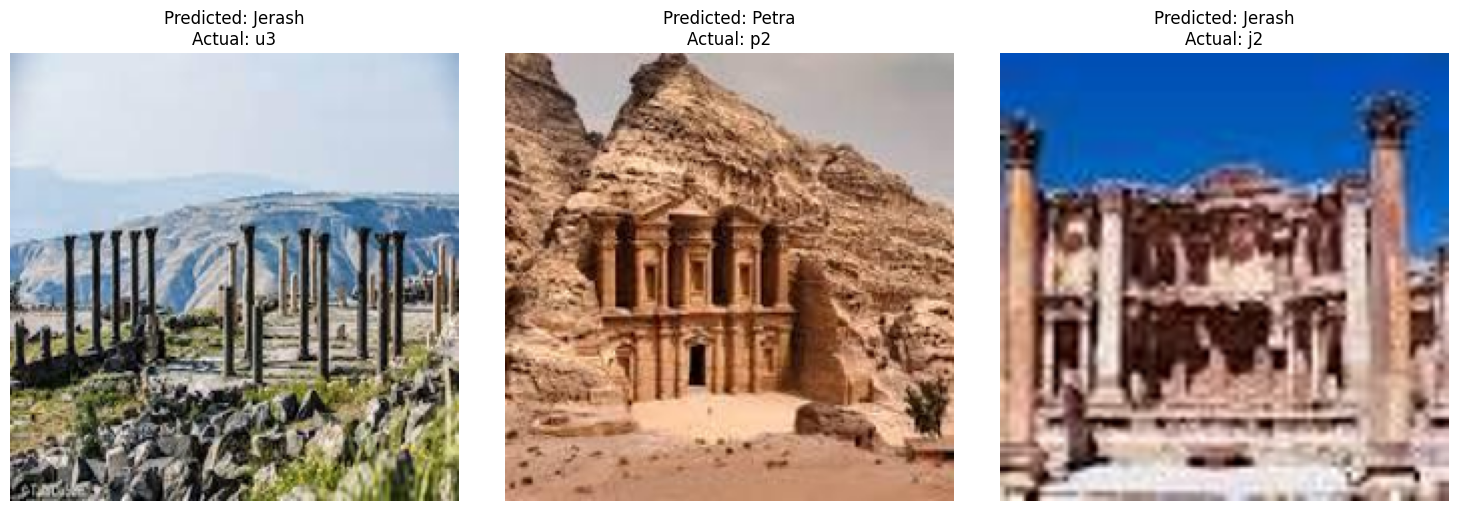

1/1 [==============================] - 0s 29ms/step


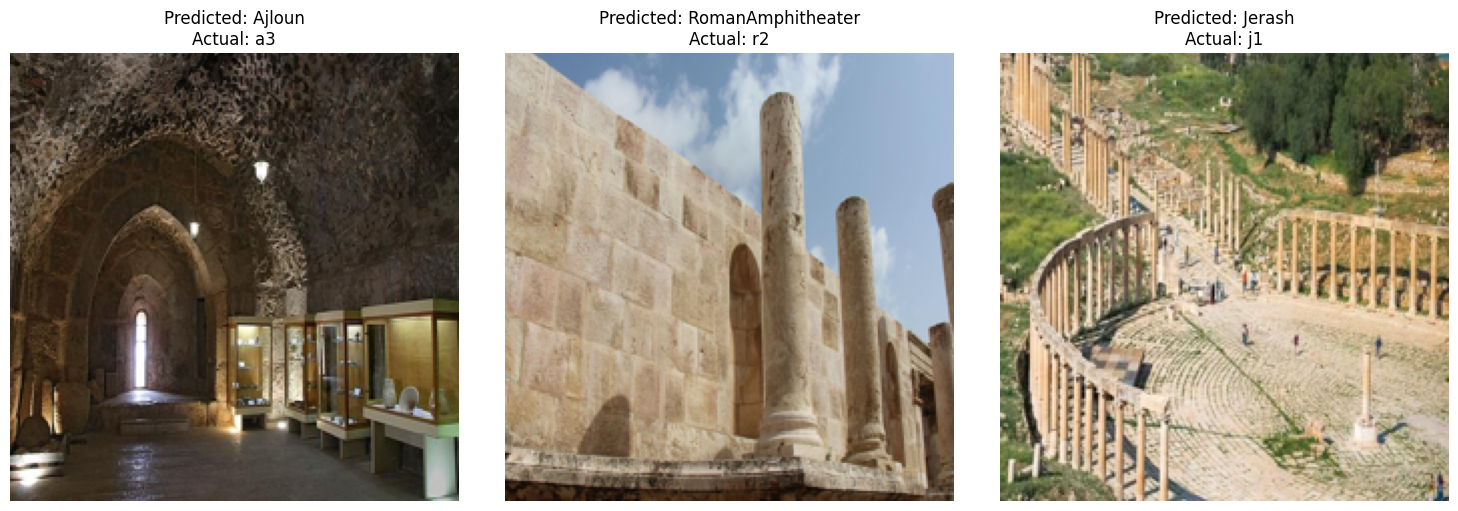

1/1 [==============================] - 0s 29ms/step


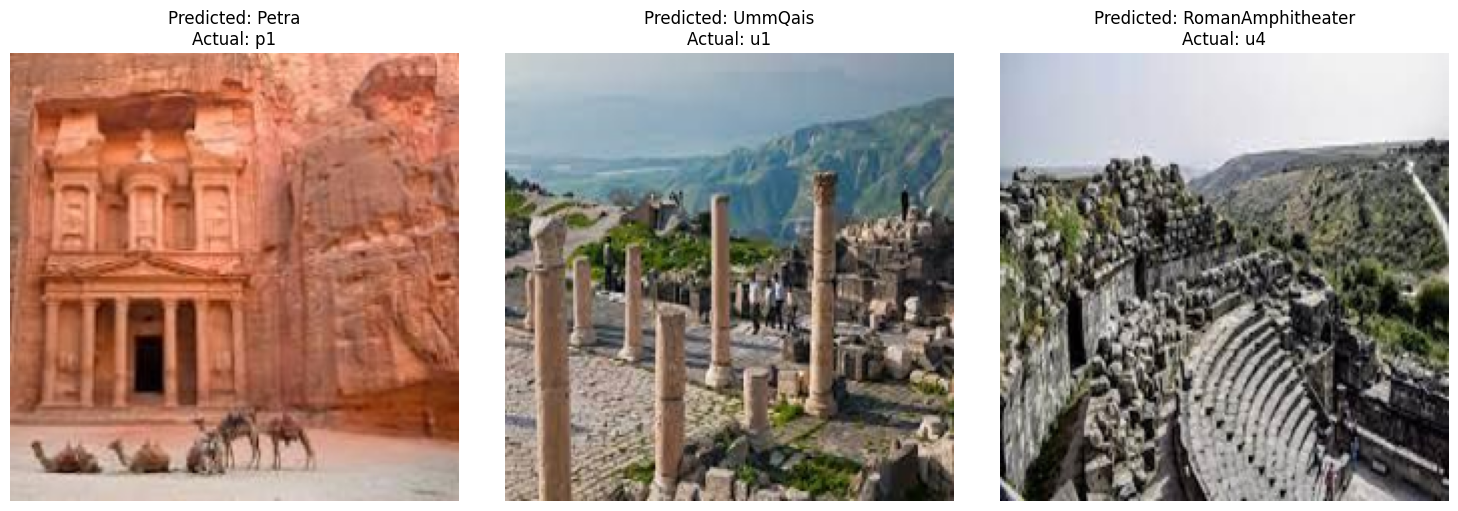

1/1 [==============================] - 0s 26ms/step


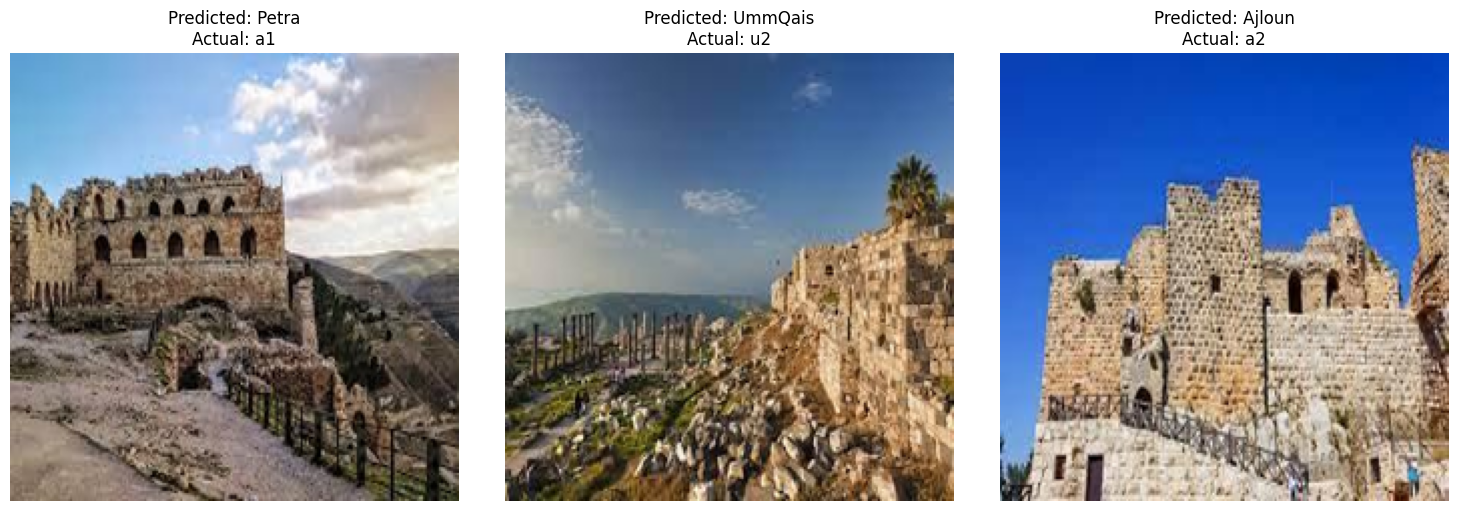

1/1 [==============================] - 0s 25ms/step


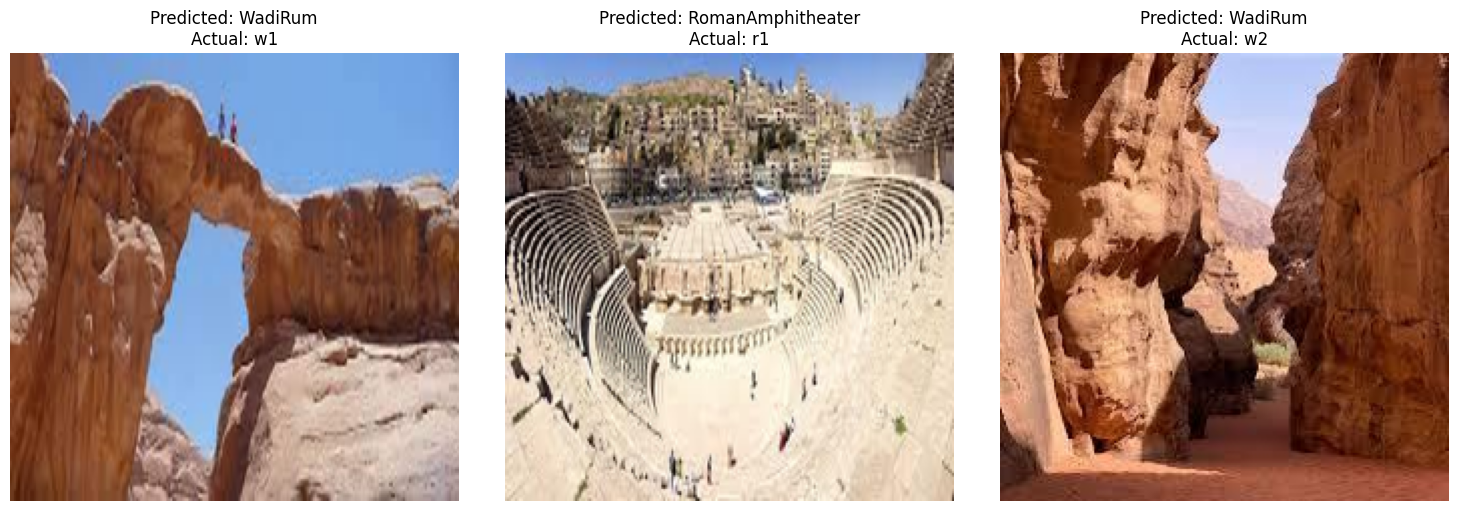

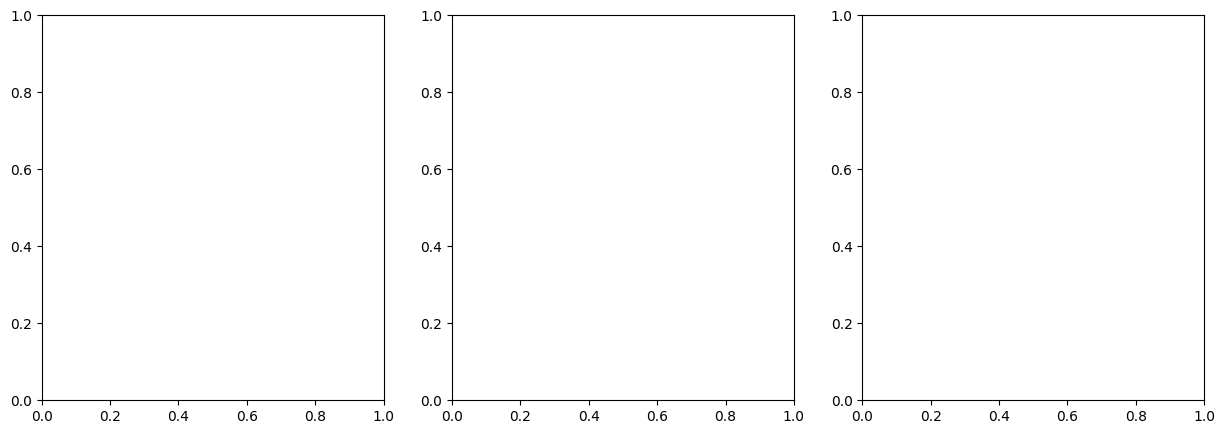

In [6]:
# Load the saved model
loaded_model = load_model('/kaggle/working/fine_tuned_EffecientNET B7_model.h5')  
# Directory containing test images
test_directory = '/kaggle/input/test-dataset/test'

# Output directory for converted images
output_directory = '/kaggle/working/converted_images/'
os.makedirs(output_directory, exist_ok=True)

class_labels = ["Ajloun", "Jerash", "Petra", "RomanAmphitheater", "UmmQais", "WadiRum"]

# Initialize counters
counter = 0
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each image in the test directory
for filename in os.listdir(test_directory):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".webp") or filename.endswith(".png"):
        # Construct the full path to the image
        img_path = os.path.join(test_directory, filename)

        # Convert the image to JPG format and save it
        converted_img_path = os.path.join(output_directory, f"{filename.split('.')[0]}.jpg")
        img = Image.open(img_path)
        img = img.convert("RGB")
        img.save(converted_img_path, "JPEG")

        # Load and preprocess the converted image
        img = Image.open(converted_img_path)
        img = img.resize((224, 224))  
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize the image

        # Make a prediction
        predictions = loaded_model.predict(img_array)

        # Get the predicted class label
        predicted_class_index = np.argmax(predictions)
        predicted_class_label = class_labels[predicted_class_index]

        # Plot the image with the predicted label and actual label
        axs[counter].imshow(img)
        axs[counter].set_title(f'Predicted: {predicted_class_label}\nActual: {filename.split(".")[0]}')
        axs[counter].axis('off')

        # Increment the counter
        counter += 1

        # If three images have been plotted, reset the counter and create a new row
        if counter == 3:
            counter = 0
            plt.tight_layout()
            plt.show()
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# If there are remaining images, display them
if counter > 0:
    plt.tight_layout()
    plt.show()
